# Predicting Education History From Credit Data

## Introduction
 
A credit card is similar to a loan where you buy items within your credit limit and pay the owing amount at the end of the month. When individuals have a credit card, there is a credit amount which is a limit on the amount they can purchase, the amount they actually purchase is their bill statement, and the previous payment is the amount that was paid last month. 

We are using the default of credit card clients dataset from the UCI Machine Learning Repository which has data on 30,000 individuals and their credit history. The dataset includes each individual’s credit amount, gender, education, marital status, age, history of past payment, amount of bill statement, and amount of previous payment. The data is from Taiwan and the currency used is the New Taiwan Dollar (\\$NT). \\$1 CAD is approximately 22 \\$NT. This dataset was originally used to see if banks could see if clients were likely to credit default. Credit default refers to when a person is unable or chooses not to pay their bill statement for the month. If a bank applies a default then it is recorded on a person's credit file and can affect their credit rating. Because of this, in the future, it may be harder for that individual to gain access to loans or other forms of credit as their score was negatively affected.

In the dataset, the education level is split into 4 categories. 1 represents graduate school, 2 represents university, 3 represents high school, and 4 represents other. The other category includes individuals who may not have completed high school or have education from colleges or trade schools.

The question we will answer is: Given a person's credit limit, age, average monthly bill, and average monthly payment what will their education level be? The reason we chose this question is that we think there may be a relationship between a person's education level and the amount of money they make and therefore their credit spending habits. We decided to try and answer this question because we feel that the benefits of having a clear answer to this question can be useful to many people. 

## Methods

Here we are loading in all the libraries that we need for the project. We are also setting the seed here so that our work can be reproduced.

In [2]:
# install required libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 8)

# setting the seed
set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Here we are loading in the data from a csv file that is stored on GitHub. After that we are cleaning up the data to get rid of columns that we don't need as well removing data points which are not clear what is being represented. After that we are splitting up the data into training and testing sets with a 50/50 split. We used a 50/50 split of training and testing data because we have about 30,000 data points so we have enough data for both accurate training and testing.

In [3]:
# reading in the data from github
url <- "https://github.com/zackhamza01/DSCI-100-Project/raw/main/data/creditcardcsv.csv"
credit_data <- read_csv(url, skip = 1)

# tidying the data
tidied_credit_data <- credit_data %>%
    mutate(BILL_AVG = (BILL_AMT1 + BILL_AMT2 + BILL_AMT3 + BILL_AMT4 + BILL_AMT5 + BILL_AMT6) / 6) %>%
    mutate(PAY_AVG = (PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT4 + PAY_AMT5 + PAY_AMT6) / 6) %>%
    select(EDUCATION, AGE, LIMIT_BAL, BILL_AVG, PAY_AVG) %>%
    mutate(EDUCATION = as_factor(EDUCATION)) %>%
    filter(EDUCATION == 1 | EDUCATION == 2 | EDUCATION == 3 | EDUCATION == 4) # getting rid of rows that have no explanation (0,5,6)

# splitting data into training and test sets
credit_split <- initial_split(tidied_credit_data, prop = 0.5, strata = EDUCATION)
credit_train <- training(credit_split)
credit_test <- testing(credit_split)

Parsed with column specification:
cols(
  .default = col_double()
)

See spec(...) for full column specifications.



Here we are creating a table to summarize our data. This table allows us to get an idea of the distributions of the different columns with respect to the different education levels. Education level 4 has a much smaller number of data points which can skew the average easily due to a few anomalies.

In [4]:
# summarizing training data in a table
summary <- credit_train %>%
    group_by(EDUCATION) %>%
    summarize(count = n(), credit_limit_avg = mean(LIMIT_BAL), age_avg = mean(AGE), 
              monthly_bill_avg = mean(BILL_AVG), monthly_payment_avg = mean(PAY_AVG))

summary

`summarise()` ungrouping output (override with `.groups` argument)



EDUCATION,count,credit_limit_avg,age_avg,monthly_bill_avg,monthly_payment_avg
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,5289,211382.1,33.98582,43113.38,6404.006
2,7012,146514.5,34.78722,45991.02,4658.952
3,2464,126262.2,40.49675,40870.97,4387.507
4,64,199687.5,33.40625,36096.56,6018.557


Summary of Training Data (Table 1)

In the table we can see the count of data points for each education level. In the next columns, we can see the average of the four different predictor variables that we are using according to education level. Overall the counts for each of the education levels vary widely so going forward these differences could affect the results of our model.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



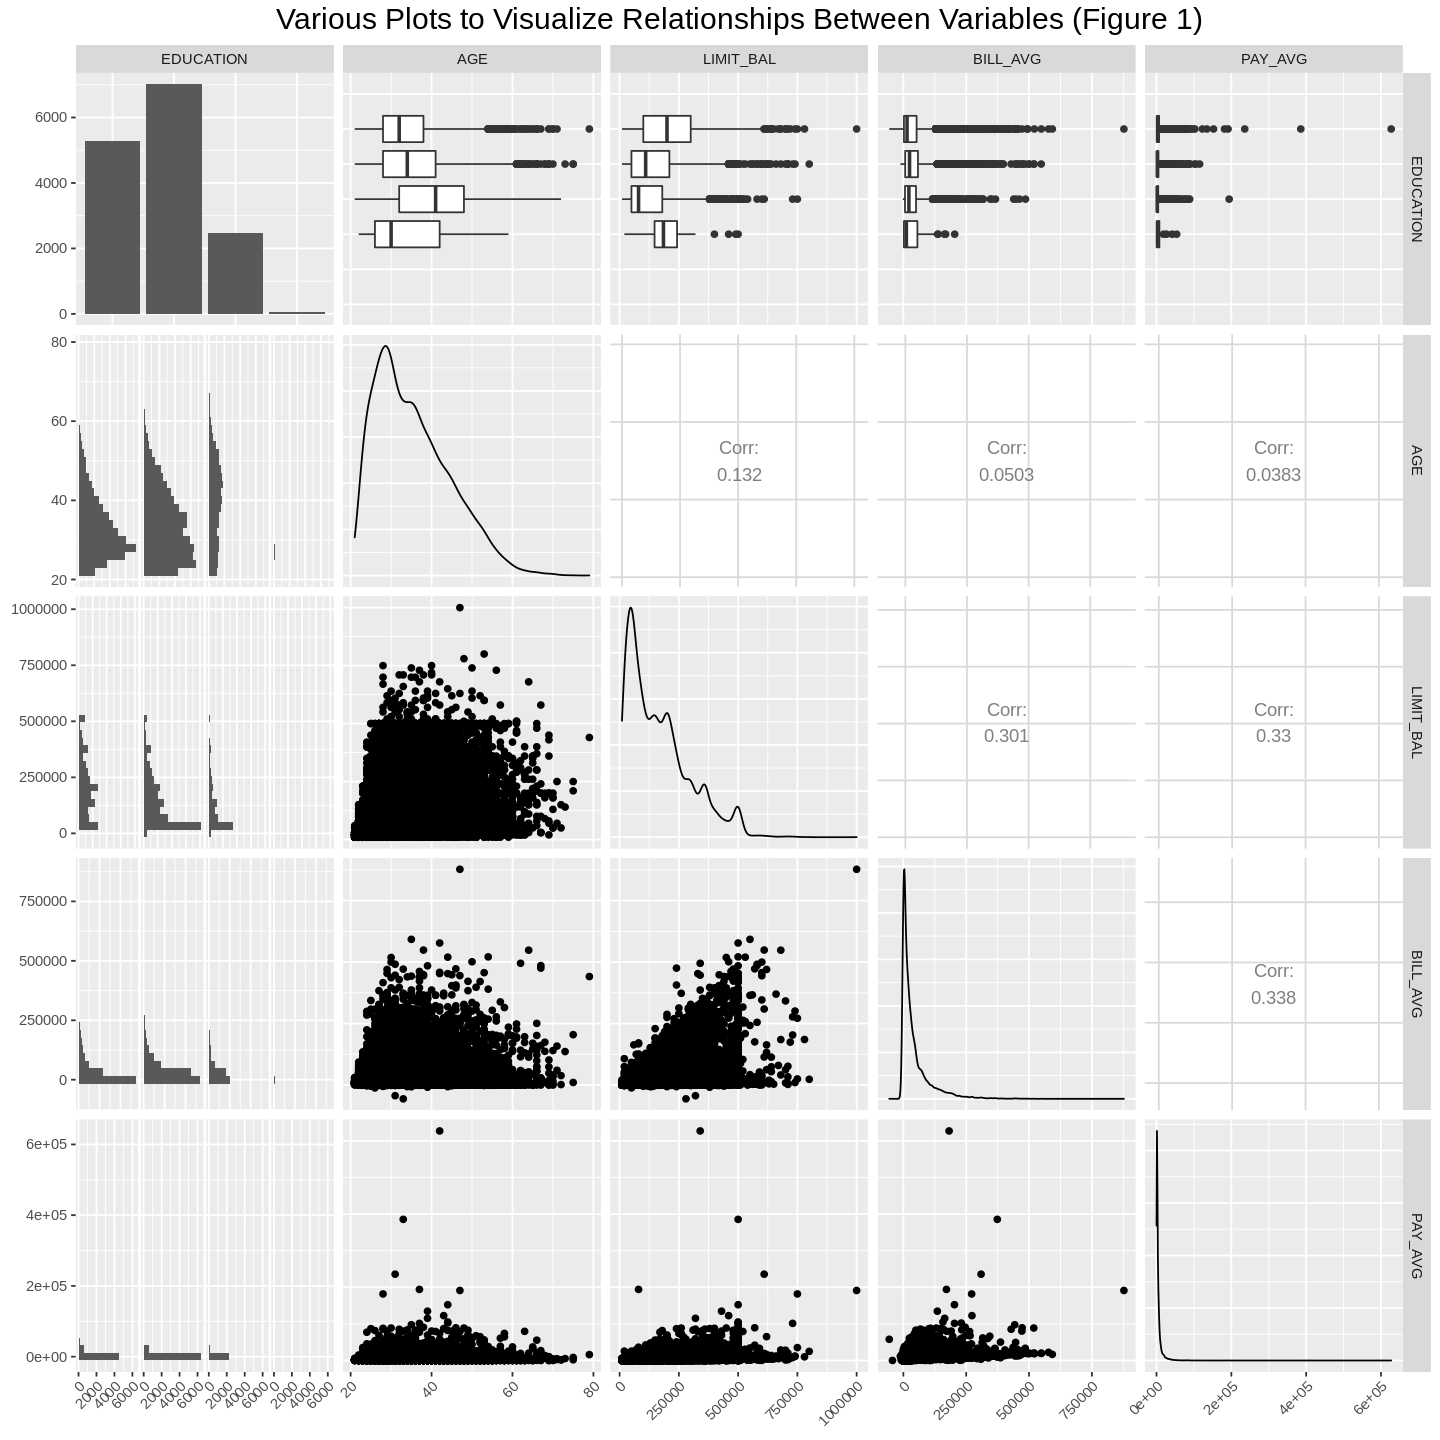

In [5]:
# visualizing data in a graph

options(repr.plot.width=12, repr.plot.height=12)

plot <- credit_train %>%
    ggpairs() +
        theme(axis.text.x=element_text(angle=45,hjust=1)) +
        ggtitle("Various Plots to Visualize Relationships Between Variables (Figure 1)") +
        theme(plot.title = element_text(size = 18, hjust = 0.5)) 

plot

From this graph, we can see that the correlation between the different predictors is fairly low so that may indicate that our prediction accuracy may also be low. The scatter plots also show us that there isn't much of a relationship between the different predictors. This is not what we were expecting since we thought that individuals with a higher credit limit would have greater spending and monthly payments but from these correlation values we can see that this is not the case. The first column of graphs is a representation of the distributions of the respective predictor variable and education level. 

First we are creating a tibble with the k values for tuning in order to see which value works best. We are using values from 1 to 50 for the possible k values as using smaller values allows us to have low variance and bias. As well using a really large k would cause the model to underfit the data. Then we create a specification for the k-nn classification model with neighbours set to to tune() so that we can try different k values. After that we are creating the recipe with the target variable as EDUCATION and using all of the other variables as predictors. All of the predictors are also scaled and centered to make sure the impact of each variable is equal. Then we create a 5-fold cross-validation set as seen in the code with v = 5 to split the training set into a validation set and another training set. Since we are using 5 fold cross-validation, the original training set will be split into 5 chunks and each chunk will be used once as the validation set. This allows us to get a better estimate of the accuracy for each k value. Finally, we fit the model to the data using the different values for k and using cross-validation.

In [11]:
# creating a tibble with the k values
k_lots <- tibble(neighbors = seq(1, 50, 5))

# creating the specification for the k-nn classification model
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                            neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

# creating the recipe for the k-nn classification model
recipe <- recipe(EDUCATION ~ ., data = credit_train) %>%
            step_scale(all_predictors()) %>%
            step_center(all_predictors())

# creating the 5-fold cross-validation set
vfold <- vfold_cv(credit_train, v = 5, strata = EDUCATION)

# fitting the model to the training data using 5-fold cross-validation
# using the k-values for tuning
credit_fit <- workflow() %>%
                add_recipe(recipe) %>%
                add_model(knn_spec) %>%
                tune_grid(resamples = vfold, grid = k_lots)

! Fold1: internal: No observations were detected in `truth` for level(s): '0', '5...

! Fold2: internal: No observations were detected in `truth` for level(s): '0', '5...

! Fold3: internal: No observations were detected in `truth` for level(s): '0', '5...

! Fold4: internal: No observations were detected in `truth` for level(s): '0', '5...

! Fold5: internal: No observations were detected in `truth` for level(s): '0', '5...



Here we are collecting the accuracy for each of the k values we used for tuning and then creating a scatter plot of the accuracies vs. k in order to determine the best k value.

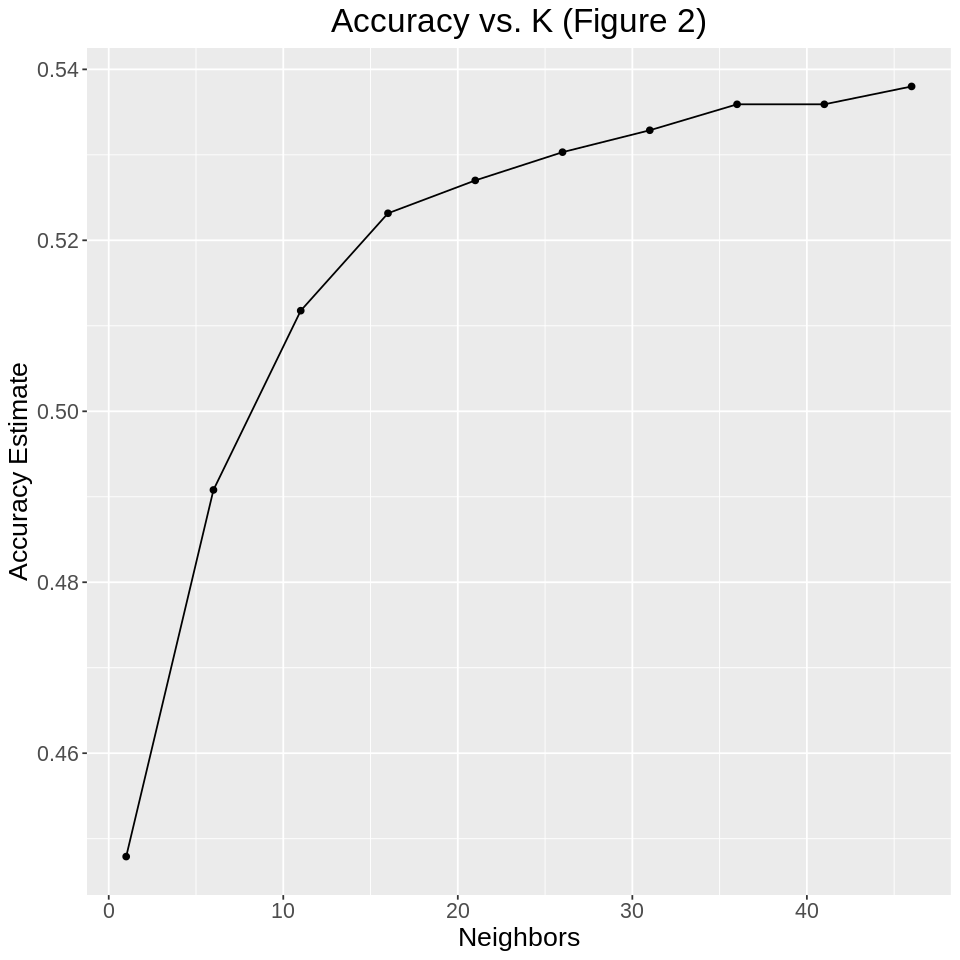

In [12]:
# collecting the accuracy values for the different k values used for tuning
accuracies <- credit_fit %>%
    collect_metrics() %>%
    filter(.metric == "accuracy")

# plot of accuracy vs k value in order to visualize what the ideal k value is
options(repr.plot.width = 8, repr.plot.height = 8)

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", 
       y = "Accuracy Estimate",
       title = "Accuracy vs. K (Figure 2)") +
  theme(plot.title = element_text(size = 20, hjust = 0.5),
        text = element_text(size = 16))

accuracy_vs_k

We chose a k value of 31 because once the graph reaches 31 the accuracy only changes slightly if we increase or decrease the k value which means that it is not an anomaly. We didn't choose a value higher than 31 because increasing the k further would make the model inefficient and it is not worth the marginal increase that it provides. Under TA recommendation, we tried testing k values up to 500, however we found that running the model took far too long and as such, we decided that the cost of increasing the k beyond this value was much greater than the small benefit in accuracy that a larger k value provided. This was caused by the limitations of the system on which we were working, and maybe more computing power would have allowed us to use a higher k value. We ultimately chose this k value as this gave us the best balance between accuracy and efficiency.

Here we first assign the value of 31 to k. We then create a new specification for the model with k = 31. Then, we fit this model to the training data. After that, we test our trained model on the testing data and collect the accuracy value. The final accuracy we get is approximately 52.7%. 

In [14]:
# setting k to 31
k <- 31

# creating the specification with k = 31
spec <- nearest_neighbor(weight_func = "rectangular",
                            neighbors = k) %>%
            set_engine("kknn") %>%
            set_mode("classification")

# fitting the training set
fit <- workflow() %>%
    add_recipe(recipe) %>%
    add_model(spec) %>%
    fit(data = credit_train)

# using the model to predict on the testing set
credit_test_predictions <- predict(fit, credit_test) %>%
    bind_cols(credit_test)

# finding the accuracy of the predictions
accuracy <- credit_test_predictions %>%
    metrics(truth = EDUCATION, estimate = .pred_class) %>%
    filter(.metric == "accuracy") %>%
    pull(.estimate)

accuracy

[1] 0.5265749

## Discussion

We found that the predictors we used which were credit limit, age, average monthly bill, and average monthly payment were not very good for predicting a person's education level. This is seen through the low accuracy values of the accuracy vs k plot (Figure 2) as well as the low prediction accuracy on the test set of 51.6%. Something strange that we found while performing our analysis was that when choosing k values, the accuracy vs. k graph was not what we expected it to be. In the graphs that we had seen previously, the accuracy would eventually start to decrease after the k values became very high, but this is not the case for our graph. The accuracy seems to remain stable at around 52-53% even when the k value was increased to 300. The reason behind this may be that our accuracy is fairly low to begin with, and also the dataset is quite large which could also affect this.

This is not what we expected to find as we believed that the predictors were relevant in predicting a person's education level. We thought that individuals with a higher education would have greater credit limit and monthly bills since these people typically hold higher paying positions. After looking at the predictor variables in the dataset we thought that these predictors were fairly relevant in predicting education and so we expected a high accuracy value but this was not the case. More specifically, we also thought that there would be stronger relationships between the predictor variables themselves. For instance, we believed that credit limit and monthly bill statement would have a strong correlation. Something that we noticed previously was that there was an imbalance in the data set for the number of points for each education level and we thought that this could affect our model. Since a weakness of k nearest neighbours classification is that it does not perform well when the classes are imbalanced, this could have been a contributing factor to our low accuracy. In the future, we could try oversampling the classes that have a lower number of data points as this may yield a higher accuracy.

The impact that our findings have is that in Taiwan the predictors we used are not accurate or useful for predicting a person's education level. Going forward, other researchers should not use these predictors as they provide a very low accuracy value. We also tested different combinations of the predictors we used and found that there was little change in the accuracy. This means that there is a low correlation between each predictor and education level. As seen in the ggpairs plot (Figure 1), the distributions for each of the predictors in relation to education level has no distinguishable patterns which also shows that there is not a strong relationship between each predictor and education level.

Some future questions that can be addressed in relation to our results are: What about our chosen predictors makes them inaccurate in predicting education level? This is important to understand why our model was so inaccurate and will hopefully will help to create more effective models going forward. What would be good predictors for an individual's education level? In the study where this dataset was found, the researchers used education as a predictor for likelihood of credit default, so then why was education useful for predicting credit default but credit data was not useful for predicting education level? Since there is a relationship one way, we would assume that the relationship would also hold in the opposite direction so why was this not the case? Why is there a low correlation between an individual's credit limit and their monthly spending? Since the dataset we used is from Taiwan, would data from other countries have different results? This is important to understand as education level and income level vary across countries which could affect our results.

## References

UCI Machine Learning Repository: Default of Credit Card Clients Data Set, archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients. 

Wilson, Greg, et al. “Good Enough Practices in Scientific Computing.” PLOS Computational Biology, vol. 13, no. 6, 2017, doi:10.1371/journal.pcbi.1005510. 

Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.

Default Notices and Default Accounts after Missing Payments.” Step Change Debt Charity, Step Change Debt Charity, www.stepchange.org/debt-info/debt-collection/default-notices-and-missed-payments.aspx. Accessed 15 Apr. 2021.
